<p><img alt="Colaboratory logo" width="324" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H1/sources/exercise-2/1-polito.png" align="left" hspace="10px" vspace="0px"></p>

<h1><strong> Homework 1 - Network Dynamics and Learning </strong></h1>
<h3>Corso di Laurea Magistrale in DATA SCIENCE AND ENGINEERING</h3>

|Student| Email|
|:--:|:--:|
|Alejandra Solarte Uscategui| s321944@studenti.polito.it|
|Alejandro Mesa Gomez | s306638@studenti.polito.it|
|Anderson Estiver Alvarez Giraldo|  s310468@studenti.polito.it|
|Juliana Cortes Mendivil| s314545@studenti.polito.it|
|Mateo Rivera Monsalve|s320923@studenti.polito.it|


## Individual contributions

|Exercise|Student |
|:--:|:--:|
|1| Alejandra Solarte, Anderson Alvarez|
|2| Mateo Rivera|
|3| Alejandro Mesa, Juliana Cortes|

## Libraries

In [1]:
#Libraries required for the notebook
from scipy.io import loadmat
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import cvxpy as cp
from collections import Counter
import copy

%matplotlib inline

# Excercise 1

## Point a

Compute the capacity of all the cuts and find the minimum capacity to be removed for no feasible flow from o to d to exist.

In [2]:
#Create the graph
def create_graph():
  global G
  G = nx.DiGraph()
  G.add_edge('o', 'a', capacity=3)  # e1
  G.add_edge('o', 'b', capacity=3)  # e3
  G.add_edge('b', 'd', capacity=2)  # e4
  G.add_edge('a', 'd', capacity=2)  # e2
  G.add_edge('a', 'b', capacity=1)  # e7
  G.add_edge('b', 'c', capacity=3)  # e5
  G.add_edge('c', 'd', capacity=1)  # e6

  return G


In [3]:
G= create_graph()

In [4]:
#Define the static positions of the nodes
pos = {"o": (40, 20), "a": (60, 35), "b": (60, 20), "c": (60, 5), "d": (80, 20)}

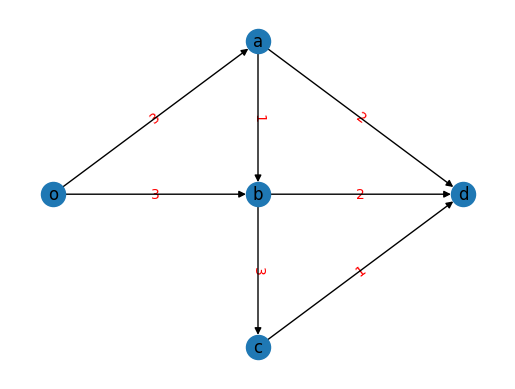

In [5]:
nx.draw_networkx_edge_labels(G,pos,edge_labels={("o","a"):'3',("o","b"):'3',("a","d"):'2',("b","d"):'2',("b","c"):'3',("c","d"):'1',("a","b"):'1'},font_color='red')
nx.draw(G, pos, with_labels=True)

According to the min-cut theorem, when we calculate the min-cut capacity, we obtain the minimum capacity among all cuts between the source and destination nodes, $o-d$.

In the maximum flow problem, a flow is feasible if it satisfies the following constraints:

*   It has no negative throughput.
*   It respects the capacity limits.
*   It maintains mass conservation at each node..

Moreover, by analyzing the min-cuts, we can observe that the minimum capacity belongs to the final cut.

The minimum total capacity that needs to be removed from the network to make
$d$ unreachable from $o$ coincides with the min-cut capacity. In this case, it corresponds to the cut between {o,a,b,c} and {d}, with a total capacity of 5.



**Cuts**
- $U=\{o\},U^C=\{a,b,c,d\}$ -> $C_U = 6$
- $U=\{o,a\},U^C=\{b,c,d\}$ -> $C_U = 6$
- $U=\{o,a,b\},U^C=\{c,d\}$ -> $C_U = 7$
- $U=\{o,a,b,c\},U^C=\{d\}$ -> $C_U = 5$

In [6]:
#Further-theorem
nx.algorithms.flow.minimum_cut(G,"o","d") #The minimum capacity to be removed for no feasible flow from o to d to exist is 5.

(5, ({'a', 'b', 'c', 'o'}, {'d'}))

In [7]:
G.edges() #Confirm the existing edges of the graph

OutEdgeView([('o', 'a'), ('o', 'b'), ('a', 'd'), ('a', 'b'), ('b', 'd'), ('b', 'c'), ('c', 'd')])

In [8]:
#Function to calculate the capacity of a given cut

def calculate_cut_capacity(U, U_complement, G):
    capacity = 0
    for u in U: #Iterate over the reachable nodes
        for v in G[u]: #Iterate over the edges of the reachable nodes
            if v in U_complement:#If the edge is shared with the non_reachable section (which in the first case would be a connection with d)
                capacity += G[u][v]['capacity']
    return capacity

In [9]:
# Cuts to do in the graph
cuts = [
    ({'o'}, {'a', 'b', 'c', 'd'}),
    ({'o', 'a'}, {'b', 'c', 'd'}),
    ({'o', 'a', 'b'}, {'c', 'd'}),
    ({'o', 'a', 'b', 'c'}, {'d'})
]

In [10]:
# Calculate the capacities of all the cuts
def get_all_capacities(G):
  capacities=[]
  for U, U_complement in cuts:
      capacity = calculate_cut_capacity(U, U_complement, G)
      capacities.append(capacity)
      print(f"U = {U}, U^C = {U_complement} -> C_U = {capacity}")

  return np.array(capacities)

In [11]:
get_all_capacities(G)

U = {'o'}, U^C = {'a', 'c', 'b', 'd'} -> C_U = 6
U = {'o', 'a'}, U^C = {'b', 'c', 'd'} -> C_U = 6
U = {'o', 'b', 'a'}, U^C = {'c', 'd'} -> C_U = 7
U = {'o', 'c', 'b', 'a'}, U^C = {'d'} -> C_U = 5


array([6, 6, 7, 5])

## Point b
You are given $x = 0$ extra units of capacity (x e Z). How should you distribute them in order to maximize the throughput that can be sent from o to d? Plot the maximum throughput from o to d as a function of $x \geq 0$.



**Max flow min cut Theorem**: the maximal flow that can send from $o$ to $d$ equals the minimal cut capacity among the o-d cuts of the network.

In [12]:
# Current maxim flow
min_cut= nx.algorithms.flow.maximum_flow(G,"o","d")
# we gey the maximal throughput, plus a dictionary containing the value of the flow that goes through each edge.
min_cut

(5,
 {'o': {'a': 3, 'b': 2},
  'a': {'d': 2, 'b': 1},
  'b': {'d': 2, 'c': 1},
  'd': {},
  'c': {'d': 1}})

The extra units of capacity should be allocated along the edges of the min-cut to balance capacities between cuts without creating or increasing bottlenecks. This allocation is done incrementally, adding one unit at a time along the min-cut edges. After each allocation, the min-cut is recalculated to check if capacities have changed or if a new min-cut has been created.

In [13]:
def compute_max_flow_min_cut(G):

    # Compute minimum cut (capacity of the cut)
    _, partition = nx.minimum_cut(G, 'o', 'd')

    # Get the edges in the minimum cut
    reachable, non_reachable = partition #In the first case the reachable variable corresponds to o,a,b,c and non_reachable to d.


    cutset={} #Start dictionary to save the edges between the cuts
    esges=[]

    for u in reachable: #Iterate over the reachable nodes
        for v in G[u]: #Iterate over the edges of the reachable nodes
            if v in non_reachable:#If the edge is shared with the non_reachable section (which in the first case would be a connection with d)
              #cutset[G[u][v]['capacity']]=(u, v) #Save the edges that connect the cuts
              esges.append((u,v))

    return esges, reachable

   # return cutset

In [14]:
G=create_graph()
borders,reachable = compute_max_flow_min_cut(G) #We get the borders that connect U and Uc

In [15]:
borders

[('c', 'd'), ('b', 'd'), ('a', 'd')]

In [16]:
reachable

{'a', 'b', 'c', 'o'}

To assign extra capacities effectively, we also need to identify the shared edges between cuts. By increasing the capacity of one of these common edges by one unit, we increase the capacity of two min-cuts simultaneously.

In [17]:
common_borders={}
common_borders[0]= [("o","b")] #The first cut share the edge e3 with the cut #2
common_borders[1]= [("a","d"), ("o","b")] #The second cut shares the edge e2 with the cut #3 and #4
common_borders[2]= [("a","d"), ("b","d")] #The third cut shares the edge e2 with the cuts #3 and #4 and e4 with the cut#4
common_borders[3]=[("a","d"), ("b","d")] #The forth cut shares the edges e2 and e4 with the cut #3

In [18]:
common_borders

{0: [('o', 'b')],
 1: [('a', 'd'), ('o', 'b')],
 2: [('a', 'd'), ('b', 'd')],
 3: [('a', 'd'), ('b', 'd')]}

When there is more than one min-cut, we need to ensure that the extra capacity is allocated to the edge shared by the min-cuts or most of them.



In [19]:
def assign_capacities(x):

  max_flows = {}
  i=0

  while True:
      if i >= x :
          break

      elif i>0:
          min_cut= nx.algorithms.flow.maximum_flow(G,"o","d")
          #calculate the borders of the min_cut
          borders,reachable = compute_max_flow_min_cut(G)
          print(f"borders{borders}")

          #Get all the mincuts
          capacities= get_all_capacities(G) #get the capacities of the cuts
          mask= capacities==min_cut[0] #Create a mask to know the cuts with the cpacity of the min_cut
          positions= np.where(mask)[0] #Position of all the mincuts

          #If just there is a mincut
          if len(positions)==1:
            #Get the minimum value of the borders of the mincut
            #min_capacity_border = min(borders.values())
            min_capacity_border = np.argmin([G[edge[0]][edge[1]]['capacity'] for edge in borders])
            print(f"cut with min capacity {np.array(cuts)[mask]}")

            #Get the border with the minimum value
            u,v =borders[min_capacity_border]
            print(f"u{u},v{v}")

            #Assign the capacity
            G[u][v]['capacity'] += 1
            print(f"The edge between {u} and {v} {G[u][v]['capacity']} has increase 1 unit")

          else:
            #get common borders of the mincuts
            cm = [common_borders[i] for i in positions]
            count=Counter(sum(cm, []))
            duplicados = [{G[elemento[0]][elemento[1]]['capacity']:elemento} for elemento, cuenta in count.items() if cuenta > 1]

            #Assign the extra capacity to the shared border with the minimum capacity
            min_duplicado = min(duplicados, key=lambda d: min(d.keys()))
            u=list(min_duplicado.values())[0][0]
            v=list(min_duplicado.values())[0][1]

            G[u][v]['capacity'] += 1
            print(f"The edge between {u} and {v} {G[u][v]['capacity']} has increase 1 unit")

          max_flows[i],_=nx.algorithms.flow.maximum_flow(G,"o","d")
          print("*"*50)
      i +=1
      print(i)

  return max_flows


1
borders[('c', 'd'), ('b', 'd'), ('a', 'd')]
U = {'o'}, U^C = {'a', 'c', 'b', 'd'} -> C_U = 6
U = {'o', 'a'}, U^C = {'b', 'c', 'd'} -> C_U = 6
U = {'o', 'b', 'a'}, U^C = {'c', 'd'} -> C_U = 7
U = {'o', 'c', 'b', 'a'}, U^C = {'d'} -> C_U = 5
cut with min capacity [[{'o', 'c', 'b', 'a'} {'d'}]]
uc,vd
The edge between c and d 2 has increase 1 unit
**************************************************
2
borders[('c', 'd'), ('b', 'd'), ('a', 'd')]
U = {'o'}, U^C = {'a', 'c', 'b', 'd'} -> C_U = 6
U = {'o', 'a'}, U^C = {'b', 'c', 'd'} -> C_U = 6
U = {'o', 'b', 'a'}, U^C = {'c', 'd'} -> C_U = 7
U = {'o', 'c', 'b', 'a'}, U^C = {'d'} -> C_U = 6
The edge between a and d 3 has increase 1 unit
**************************************************
3
borders[('o', 'a'), ('o', 'b')]
U = {'o'}, U^C = {'a', 'c', 'b', 'd'} -> C_U = 6
U = {'o', 'a'}, U^C = {'b', 'c', 'd'} -> C_U = 7
U = {'o', 'b', 'a'}, U^C = {'c', 'd'} -> C_U = 8
U = {'o', 'c', 'b', 'a'}, U^C = {'d'} -> C_U = 7
cut with min capacity [[{'o'} {

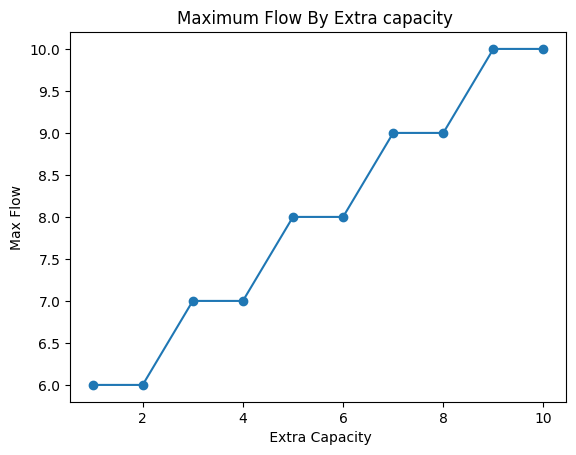

In [20]:
max_flows = assign_capacities(11)

plt.plot(max_flows.keys(), max_flows.values(), marker = 'o')

# Plot formatting
plt.xlabel(' Extra Capacity')
plt.ylabel('Max Flow')
plt.title('Maximum Flow By Extra capacity ')
plt.show()

From the image, we can observe that the maximum flow is directly correlated with the extra capacity, increasing proportionally as the capacity increases.

## Point c

You are given the possibility of adding to the network a directed link e8 with capacity c8= 1 and x > O extra units of capacity $(X \in Z)$. Where should you add the link and how should you distribute the additional capacity in order to maximize the throughput that can be sent from o to Plot the maximum throughput from o to d as a function of $x \ge 0$.


In [21]:
#Recreate the original graph
G=create_graph()
G.add_edge('o', 'd', capacity=1) #add directed link e8
pos = nx.nx_pydot.graphviz_layout(G)

In the original graph, the min-cut is between the sets $\{𝑎,𝑏,𝑐,o \}$ and $\{d\}$. To add the edge $e_8$ , we should place it in this bottleneck, where there is a missing directed link between nodes $o$ and $d$. Including this edge in the capacity calculation will directly increase the total capacity. By adding this edge between $o$ and $d$, we aim to maximize the throughput, as the maximum throughput corresponds to the min-cut capacity.

In [22]:
G.edges() #Confirming the new edge in the graph

OutEdgeView([('o', 'a'), ('o', 'b'), ('o', 'd'), ('a', 'd'), ('a', 'b'), ('b', 'd'), ('b', 'c'), ('c', 'd')])

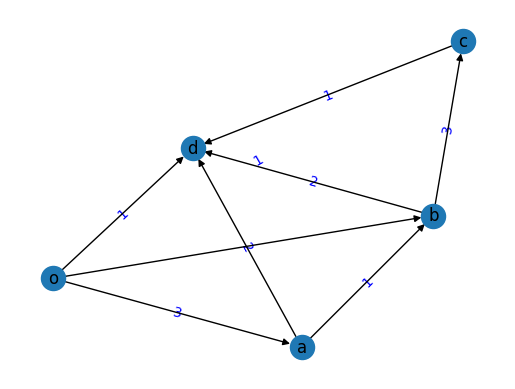

In [23]:
#Plot the graph
nx.draw_networkx_edge_labels(G,pos,edge_labels={("o","a"):'3',("o","b"):'3',("a","d"):'2',("b","d"):'2',("b","c"):'3',("c","d"):'1',("a","b"):'1', ("o","c"):1, ("o", "d"):1},font_color='blue')
nx.draw(G, pos, with_labels=True) #We have two rows so it is an undirected graph

In [24]:
#The cuts remains the same
cuts = [
    ({'o'}, {'a', 'b', 'c', 'd'}),
    ({'o', 'a'}, {'b', 'c', 'd'}),
    ({'o', 'a', 'b'}, {'c', 'd'}),
    ({'o', 'a', 'b', 'c'}, {'d'})
]

In [25]:
#The new edge between o and d is common in all the cuts
common_borders={}
common_borders[0]= [("o","b"),("o", "d")]
common_borders[1]= [("a","d"), ("o","b"),("o", "d")]
common_borders[2]= [("a","d"), ("b","d"),("o", "d")]
common_borders[3]=[("a","d"), ("b","d"),("o", "d")]

1
borders[('o', 'd'), ('c', 'd'), ('b', 'd'), ('a', 'd')]
U = {'o'}, U^C = {'a', 'c', 'b', 'd'} -> C_U = 7
U = {'o', 'a'}, U^C = {'b', 'c', 'd'} -> C_U = 7
U = {'o', 'b', 'a'}, U^C = {'c', 'd'} -> C_U = 8
U = {'o', 'c', 'b', 'a'}, U^C = {'d'} -> C_U = 6
cut with min capacity [[{'o', 'c', 'b', 'a'} {'d'}]]
uo,vd
The edge between o and d 2 has increase 1 unit
**************************************************
2
borders[('o', 'd'), ('c', 'd'), ('b', 'd'), ('a', 'd')]
U = {'o'}, U^C = {'a', 'c', 'b', 'd'} -> C_U = 8
U = {'o', 'a'}, U^C = {'b', 'c', 'd'} -> C_U = 8
U = {'o', 'b', 'a'}, U^C = {'c', 'd'} -> C_U = 9
U = {'o', 'c', 'b', 'a'}, U^C = {'d'} -> C_U = 7
cut with min capacity [[{'o', 'c', 'b', 'a'} {'d'}]]
uc,vd
The edge between c and d 2 has increase 1 unit
**************************************************
3
borders[('o', 'd'), ('c', 'd'), ('b', 'd'), ('a', 'd')]
U = {'o'}, U^C = {'a', 'c', 'b', 'd'} -> C_U = 8
U = {'o', 'a'}, U^C = {'b', 'c', 'd'} -> C_U = 8
U = {'o', 'b', 'a'}, U

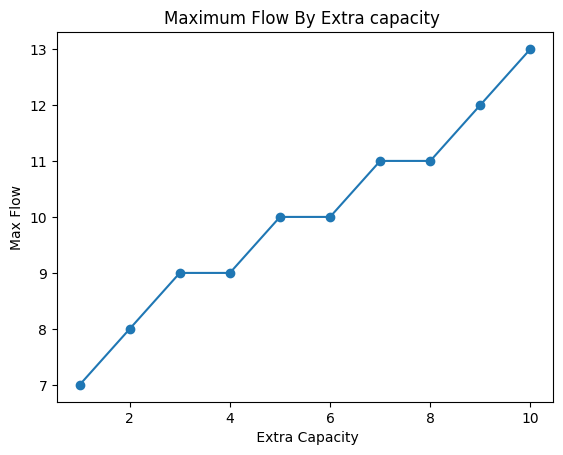

In [26]:
#Use the previous function to know where to allocate the extra capacity
max_flows = assign_capacities(11)


plt.plot(max_flows.keys(), max_flows.values(), marker = 'o')

# Plot formatting
plt.xlabel(' Extra Capacity')
plt.ylabel('Max Flow')
plt.title('Maximum Flow By Extra capacity ')
plt.show()

When we add an extra edge from $o$ to $d$, the min-cuts improve more quickly due to the presence of a direct path from the start to the end of the graph.

# Exercise 2
There are a set of people $\left\{ a_{1},a_{2},a_{3},a_{4} \right\}$ and a set of foods $\left\{ b_{1},b_{2},b_{3},b_{4} \right\}$. Each person is interested in a subset of foods, specifically $$a_{1} \to \left\{b_{1},b_{2}\right\}, a_{2} \to \left\{b_{2},b_{3}\right\}, a_{3} \to \left\{b_{1},b_{4}\right\}, a_{4} \to \left\{b_{1},b_{2},b_{4}\right\}$$

## Point a
Exploit max-flow problems to find a perfect match (if any).

**Solution**

In this case, we have a bipartite graph $G=\left( V=V_{0} \bigcup V_{1}, E\right)$, where $V_{0}=\left\{ a_{i}\right\}^{4}_{i=1}$, $V_{1}=\left\{ b_{i}\right\}^{4}_{i=1}$, $E_{1}=\left\{ \left( a_{1}, b_{1} \right), \left( a_{1}, b_{2} \right), \left( a_{2}, b_{2} \right), \left( a_{2}, b_{3} \right), \left( a_{3}, b_{1} \right), \left( a_{3}, b_{4} \right), \left( a_{4}, b_{1} \right), \left( a_{4}, b_{2} \right), \left( a_{4}, b_{4} \right) \right\}$, $E_{2}=\left\{ \left ( j,i \right ):\left ( i,j \right ) \in E_{1} \right\}$, $E=E_{1} \bigcup E_{2}$

<div>
<img width="256" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H1/sources/exercise-2/G.png"/>
</div>

Let us consider the following capacitated directed multigraph $G_{a}=\left( V_{a}=\left\{ o \right\} \bigcup V \bigcup \left\{ d \right\}, E_{a}= \left\{ \left( o,i \right):i \in V_{0} \right\} \bigcup E_{1} \bigcup \left\{ \left( i,d \right):i \in V_{1} \right\}, \vec{c} \right)$ where $\vec{c} \in \mathbb{R}^{E_{a}}$, $c_{e}=\left\{\begin{matrix}
1 & if & e \in E_{a}\setminus E_{1} \\
\left| V_{0} \right| +1 = 5 & if & e \in E_{1} \\
\end{matrix}\right.$

<div>
<img width="624" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H1/sources/exercise-2/Ga.png"/>
</div>

In [27]:
# G = (V = V0 U V1, E = E1 U E2)
V0 = [f'a{i}' for i in range(1, 4 + 1)]
V1 = [f'b{i}' for i in range(1, 4 + 1)]
V = V0 + V1
E1 = [('a1', 'b1'), ('a1', 'b2'), ('a2', 'b2'), ('a2', 'b3'), ('a3', 'b1'), ('a3', 'b4'), ('a4', 'b1'), ('a4', 'b2'), ('a4', 'b4')]
E2 = copy.deepcopy(E1)
E2.reverse()
E = E1 + E2

cardinality_V0 = len(V0)
cardinality_V1 = len(V1)

# G_a = (V_a = {0} U V U {d}, E_a = {(o, j)| j \in V0} U E1 U {(i, d)| i \in V1})
V_a = ['o'] + V + ['d']
E_a = [("o", f"a{i}") for i in range(1, 4 + 1)] + E1 + [(f'b{i}', 'd') for i in range(1, 4 + 1)]

n_nodes_G_bar = 1 +  cardinality_V0 + cardinality_V1 + 1

G_a = nx.DiGraph()

for e in E_a:
    G_a.add_edge(e[0], e[1], capacity=cardinality_V0 + 1 if e in E1 else 1)

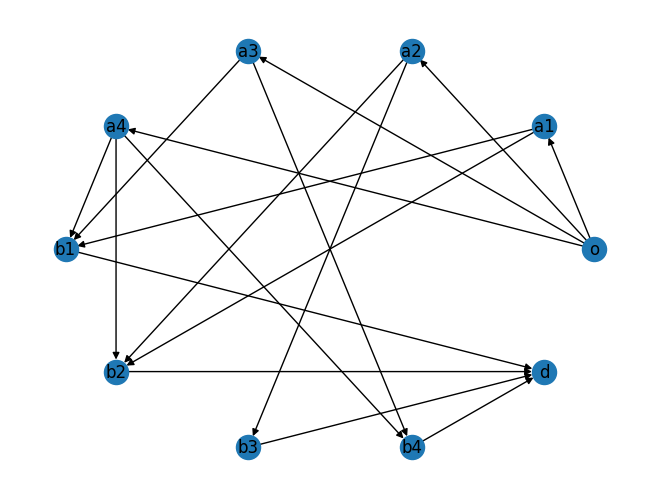

In [28]:
nx.draw_circular(G_a, with_labels=True)

"By constructing this network, the goal is to show that there is a maximum flow from $o$ to $d$ of value $\left| V_{0} \right|$; if this flow exists, it implies that each node in $V_{0}$ can be matched to a distinct node in $V_{1}$, satisfying Hall's condition for a perfect matching"

Let us apply Ford and Fulkerson's algorithm over $G_{a}$ using the library `NetworkX`, in particular the function `nx.maximum_flow`

In [29]:
flow_value_a, flow_dict_a = nx.maximum_flow(G_a, "o", "d")

In [30]:
flow_dict_a

{'o': {'a1': 1, 'a2': 1, 'a3': 1, 'a4': 1},
 'a1': {'b1': 0, 'b2': 1},
 'a2': {'b2': 0, 'b3': 1},
 'a3': {'b1': 1, 'b4': 0},
 'a4': {'b1': 0, 'b2': 0, 'b4': 1},
 'b1': {'d': 1},
 'b2': {'d': 1},
 'b3': {'d': 1},
 'b4': {'d': 1},
 'd': {}}

In [31]:
F = [(i, j) for i in flow_dict_a for j in flow_dict_a[i] if flow_dict_a[i][j] == 1 and i != 'o' and j != 'd']
F

[('a1', 'b2'), ('a2', 'b3'), ('a3', 'b1'), ('a4', 'b4')]

And we get a perfect matching because $\left|F\right|=\left|\left\{ \left( a_{1},b_{2} \right), \left( a_{2},b_{3} \right),\left( a_{3},b_{1} \right), \left( a_{4},b_{4} \right)\right\}\right|=\left|V_{0}\right|=\left|V_{1}\right|$
<div>
<img src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H1/sources/exercise-2/Ra.png" width="412"/>
</div>

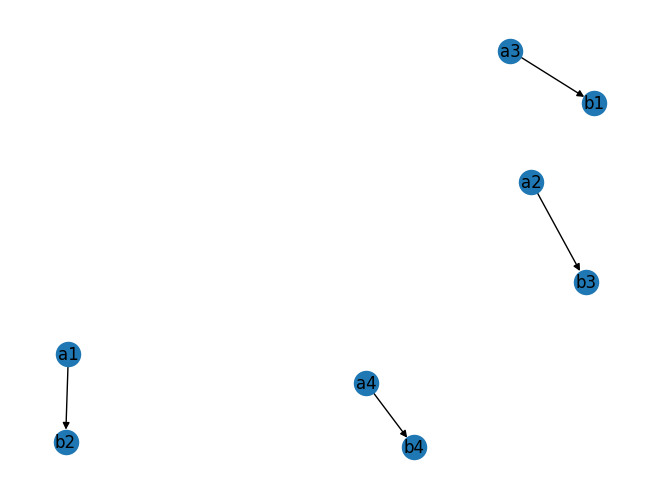

In [32]:
nx.draw(nx.DiGraph(F), with_labels = True)

## Point b
Now, assume that there are multiple portions of every food, and the distribution of the portions is $\begin{pmatrix}
2 & 3 & 2 & 2 \\
\end{pmatrix}$. Each person can take an arbitrary number of *different* foods. Exploit the analogy with max-flow problems to establish how many portions of food can be assign in total.

**Solution**

People can take an arbitrary number of different foods, this means that each person can take one portion from each of the foods they are interested in, but not multiple portions of the same type of food, so it is correct to say that the edges linking people with to their preferences have a capacity of one.
We have an additional constraint: The portion distribution of each food is limited, meaning that each food node has a capacity. This concept is called "Maximum flow with vertex capacities", where we aim to maximize the flow under the constraint of vertex capacities.

Let us illustrate this by considering the same graph $G_{a}$
<div>
<img width="624" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H1/sources/exercise-2/Gb1.png"
</div>

Let us define the portion distribution for each food as $\vec{k}=\begin{pmatrix}
2 & 3 & 2 & 2 \\
\end{pmatrix} \in \mathbb{R}^{V_{1}}_{+}$ where $k_{i}$ represents the capacity of node $b_{i}$ and $\vec{c}=\vec{1} \in \mathbb{R}^{E_{1}}_{+}$ represents the capacities of the edges in $E_{1}$

The flow $\vec{f}$ has to satisfy the capacity constraint, conservation flows and vertex capacity constraint: $\sum_{i \in V}f_{ij}\leq k_{j}$ $\forall j\in V_{1}$

The way to address this problem will be as Trevisan (From Stanford University) suggests:

"... the problem can be reduced to the standard maximum flow problem, by splitting every vertex $v$ into two vertices $v_{in}$ and $v_{out}$, adding one edge $\left(v_{in}, v_{out} \right)$ of capacity $c_{v}$, and then converting every edge $\left( u,v\right)$ to an edge $\left( u, v_{in} \right)$ and every edge $\left(v,w\right)$ to an edge $\left(v_{out},w\right)$. It is easy to show that solving the (standard) maximum flow problem on the new network is equivalent to solving the maximum flow with vertex capacity constraints in the original network".

So, our graph becomes the following:
<div>
<img width="800" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H1/sources/exercise-2/Gb2.png"/>
</div>

More formally $G_{b}=\left( V_{b}=\left\{ o \right\} \bigcup V_{0} \bigcup V_{1\left( in \right)} = \left\{ b_{i \left(in \right)}\right\}^{4}_{i=1} \bigcup V_{1\left( out \right)} = \left\{ b_{i \left(out \right)}\right\}^{4}_{i=1}\bigcup \left\{ d \right\}, E_{b}= \left\{ \left( o,i \right):i \in V_{0} \right\} \bigcup \left\{ \left( i,j_{\left(in \right)} \right):\left(i,j \right) \in E_{1} \right\} \bigcup \left\{ \left(b_{i\left( in\right)}, b_{i\left( out \right)} \right) \right\}^{4}_{i=1} \bigcup \left\{ \left( i,d \right):i \in V_{1} \right\}, \vec{c} \right)$ where $\vec{c} \in \mathbb{R}^{E_{b}} $, $c_{e}=\left\{\begin{matrix}
+\infty  & if & e \in \left\{ \left(o, i \right):i \in V_{0} \right\} \bigcup \left\{ \left(i, d \right):i \in V_{1\left( out \right)} \right\} \\
1 & if & e \in \left\{ \left(i, j_{\left(in \right)} \right): \left( i,j \right) \in E_{1} \right\} \\
2 & if & e = \left( b_{i\left(in\right)}, b_{i\left(out\right)}\right), i=1,3,4\\
3 & if & e = \left( b_{2\left(in\right)}, b_{2\left(out\right)}\right)\\
\end{matrix}\right.$

In [33]:
V_b = ['o'] + [f'a{i}' for i in range(1, 4 + 1)] + [f'b{i}_in' for i in range(1, 4 + 1)] + [f'b{i}_out' for i in range(1, 4 + 1)] + ['d']
V_b

['o',
 'a1',
 'a2',
 'a3',
 'a4',
 'b1_in',
 'b2_in',
 'b3_in',
 'b4_in',
 'b1_out',
 'b2_out',
 'b3_out',
 'b4_out',
 'd']

In [34]:
E_b = []
for e in E_a:
    if 'b' in e[1]:
        E_b.append((e[0], e[1] + '_in'))
    elif 'b' in e[0]:
        E_b.append((e[0] + '_out', e[1]))
    else:
        E_b.append(e)
E_b += [(f'b{i}_in', f'b{i}_out') for i in range(1, 4 + 1)]
E_b

[('o', 'a1'),
 ('o', 'a2'),
 ('o', 'a3'),
 ('o', 'a4'),
 ('a1', 'b1_in'),
 ('a1', 'b2_in'),
 ('a2', 'b2_in'),
 ('a2', 'b3_in'),
 ('a3', 'b1_in'),
 ('a3', 'b4_in'),
 ('a4', 'b1_in'),
 ('a4', 'b2_in'),
 ('a4', 'b4_in'),
 ('b1_out', 'd'),
 ('b2_out', 'd'),
 ('b3_out', 'd'),
 ('b4_out', 'd'),
 ('b1_in', 'b1_out'),
 ('b2_in', 'b2_out'),
 ('b3_in', 'b3_out'),
 ('b4_in', 'b4_out')]

In [35]:
n_nodes_G_b = 1 + cardinality_V0 + cardinality_V1 + cardinality_V1 + 1
n_nodes_G_b

14

In [36]:
capacities = {
    ('b1_in', 'b1_out'): 2,
    ('b2_in', 'b2_out'): 3,
    ('b3_in', 'b3_out'): 2,
    ('b4_in', 'b4_out'): 2
    }
capacities

{('b1_in', 'b1_out'): 2,
 ('b2_in', 'b2_out'): 3,
 ('b3_in', 'b3_out'): 2,
 ('b4_in', 'b4_out'): 2}

In [37]:
G_b = nx.DiGraph()

for e in E_b:
    if 'b' in e[0] and 'b' in e[1]:
        G_b.add_edge(e[0], e[1], capacity=capacities[e])
    elif 'a' in e[0]:
        G_b.add_edge(e[0], e[1], capacity=1)
    else:
        G_b.add_edge(e[0], e[1])

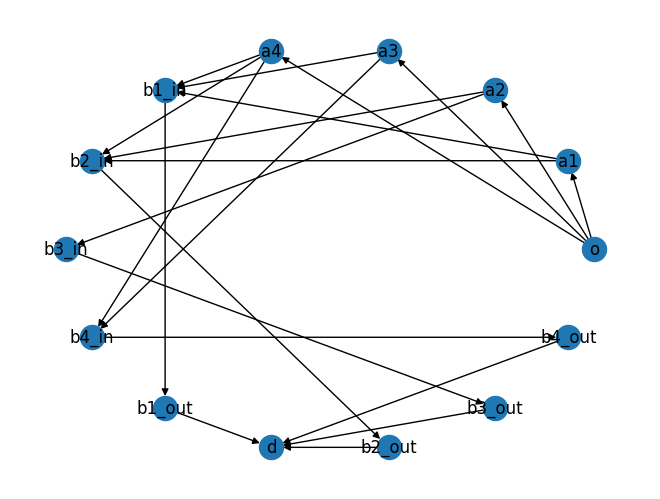

In [38]:
nx.draw_circular(G_b, with_labels=True)

Let us apply Ford and Fulkerson's algorithm over $G_{b}$ using the same library and function as before, we obtain the following result

In [39]:
flow_value_b, flow_dict_b = nx.maximum_flow(G_b, "o", "d")
flow_value_b, flow_dict_b

(8,
 {'o': {'a1': 1, 'a2': 2, 'a3': 2, 'a4': 3},
  'a1': {'b1_in': 0, 'b2_in': 1},
  'a2': {'b2_in': 1, 'b3_in': 1},
  'a3': {'b1_in': 1, 'b4_in': 1},
  'a4': {'b1_in': 1, 'b2_in': 1, 'b4_in': 1},
  'b1_in': {'b1_out': 2},
  'b2_in': {'b2_out': 3},
  'b3_in': {'b3_out': 1},
  'b4_in': {'b4_out': 2},
  'b1_out': {'d': 2},
  'd': {},
  'b2_out': {'d': 3},
  'b3_out': {'d': 1},
  'b4_out': {'d': 2}})

We can conclude that the total number of food portions that can be assigned is 8, distributed as follows:
$$a_{1}\to \left\{ b_{2}\right\}$$
$$a_{2}\to \left\{ b_{2}, b_{3}\right\}$$
$$a_{3}\to \left\{ b_{1}, b_{4}\right\}$$
$$a_{4}\to \left\{ b_{1}, b_{2}, b_{4}\right\}$$
This means that $a_{1}$ receives one portion of $b_{2}$, $a_{2}$ receives one portion of $b_{2}$ and one portion of $b_{3}$ and so on.
Visually, this shows the distribution clearly:
<div>
<img width="412" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H1/sources/exercise-2/Rb.png" />
</div>

## Point c
Now, assume that $a_{1}$ wants $3$ portions of food, $a_{i}$ (For every $i\neq1$) want $2$ portions of food, every person can take multiple portions of the same food, and the distribution of the portions is $\begin{pmatrix}
2 & 3 & 2 & 2 \\
\end{pmatrix}$. Exploit the analogy with max-flow problems to establish how many portions of food can be assign in total.

**Solution**

In this part of the exercise, we will consider  the graph $G_{b}$ but with a different distribution of capacities.
In this way, we will take into account each person's preferences
<div>
<img width="824" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H1/sources/exercise-2/Gc.png">
</div>

More formally $G_{c}=\left(V_{b}, E_{b}, \vec{c} \right)$ where $\vec{c} \in \mathbb{R}^{E_{b}}$,
$c_{e}=\left\{\begin{matrix}
3  & if & e \in \left\{ \left( o, a_{1} \right), \left( b_{2\left(in\right)}, b_{2\left( out \right)} \right) \right\} \\
2 & if & e \in \left\{ \left(o, a_{i} \right): 2\leq i \leq 4 \right\} \bigcup \left\{\left( b_{i\left(in\right)},b_{i\left(out\right)}\right) : i=1, 3, 4\right\} \\
+\infty & if & e \in \left\{ \left(i, j_{\left(in \right)} \right): \left( i,j \right) \in E_{1} \right\} \bigcup \left\{ \left(b_{i\left(out\right)}, d \right):1\leq i\leq4\right\} \\
\end{matrix}\right.$

In [40]:
capacities |= {('o', 'a1'): 3} | {('o', f'a{i}'): 2 for i in range(2, 4 + 1)}
capacities

{('b1_in', 'b1_out'): 2,
 ('b2_in', 'b2_out'): 3,
 ('b3_in', 'b3_out'): 2,
 ('b4_in', 'b4_out'): 2,
 ('o', 'a1'): 3,
 ('o', 'a2'): 2,
 ('o', 'a3'): 2,
 ('o', 'a4'): 2}

In [41]:
G_c = nx.DiGraph()

for e in E_b:
    if e in capacities.keys():
        G_c.add_edge(e[0], e[1], capacity=capacities[e])
    else:
        G_c.add_edge(e[0], e[1])

In [42]:
G_c.edges.data()

OutEdgeDataView([('o', 'a1', {'capacity': 3}), ('o', 'a2', {'capacity': 2}), ('o', 'a3', {'capacity': 2}), ('o', 'a4', {'capacity': 2}), ('a1', 'b1_in', {}), ('a1', 'b2_in', {}), ('a2', 'b2_in', {}), ('a2', 'b3_in', {}), ('a3', 'b1_in', {}), ('a3', 'b4_in', {}), ('a4', 'b1_in', {}), ('a4', 'b2_in', {}), ('a4', 'b4_in', {}), ('b1_in', 'b1_out', {'capacity': 2}), ('b2_in', 'b2_out', {'capacity': 3}), ('b3_in', 'b3_out', {'capacity': 2}), ('b4_in', 'b4_out', {'capacity': 2}), ('b1_out', 'd', {}), ('b2_out', 'd', {}), ('b3_out', 'd', {}), ('b4_out', 'd', {})])

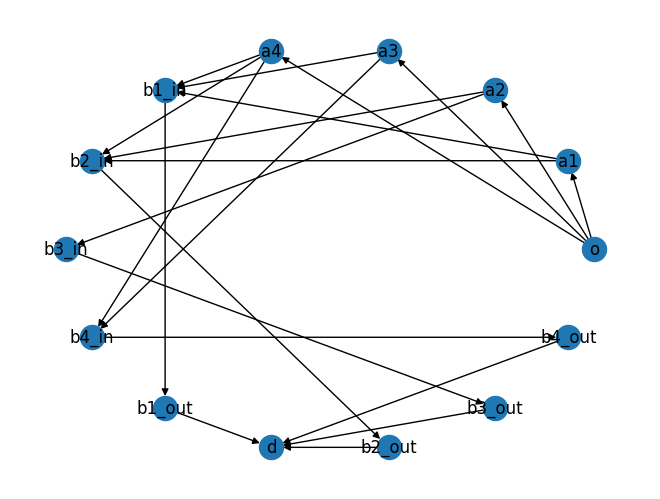

In [43]:
nx.draw_circular(G_c, with_labels=True)

After implementing this graph with `NetworkX` library and using the same function as before, we obtain the following result

In [44]:
flow_value_c, flow_dict_c = nx.maximum_flow(G_c, "o", "d")
flow_value_c, flow_dict_c

(9,
 {'o': {'a1': 3, 'a2': 2, 'a3': 2, 'a4': 2},
  'a1': {'b1_in': 0, 'b2_in': 3},
  'a2': {'b2_in': 0, 'b3_in': 2},
  'a3': {'b1_in': 2, 'b4_in': 0},
  'a4': {'b1_in': 0, 'b2_in': 0, 'b4_in': 2},
  'b1_in': {'b1_out': 2},
  'b2_in': {'b2_out': 3},
  'b3_in': {'b3_out': 2},
  'b4_in': {'b4_out': 2},
  'b1_out': {'d': 2},
  'd': {},
  'b2_out': {'d': 3},
  'b3_out': {'d': 2},
  'b4_out': {'d': 2}})

We can conclude that the total number of food portions that can be assigned is $9$ (The whole table) distributed of the following way:
$$a_{1}\to \left\{ b_{2}:3\right\}$$
$$a_{2}\to \left\{ b_{3}:2\right\}$$
$$a_{3}\to \left\{ b_{1}:2\right\}$$
$$a_{4}\to \left\{ b_{4}:2\right\}$$
This means that $a_{1}$ receives three ($3$) portions of $b_{2}$, $a_{2}$ receives two ($2$) portions of $b_{3}$ and so on.
Visually, this shows the distribution clearly:
<div>
<img width="412" src="https://raw.githubusercontent.com/MateoRivera/network-dynamics/main/H1/sources/exercise-2/Rc.png"/>
</div>

In [45]:
#Auxiliary instructions that allow to run the scripts in the cloud
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/MateoRivera/network-dynamics/refs/heads/main/H1/init.py?token=GHSAT0AAAAAACZHWD3M4LTCY4SSOFRQD7KWZZFABIQ
from init import init; init(force_download=False)


replicating local resources


# Exercise 3
We are given the highway network in Los Angeles, see Figure 2. To simplify the
problem, an approximate highway map is given in Figure 3, covering part of the real highway network. The node-link incidence matrix $B$, for this traffic network is given in the file `traffic.mat`. The rows of $B$ are associated with the nodes of the network and the columns of $B$ with the links. The $i$-th column of $B$ has $1$ in the row corresponding to the tail node of link $e_i$ and $(-1)$ in the row corresponding to the head node of link $e_i$ . Each node represents an intersection between highways (and some of the area around).

Each link $e_i \in \{e_1 , . . . , e_{28} \}$, has a maximum flow capacity $c_{ei}$. The capacities are given as a vector $c_e$ in the file `capacities.mat`. Furthermore, each link has a minimum travelling time lei, which the drivers experience when the road is empty. In the same manner as for the capacities, the minimum travelling times are given as a vector le in the file `traveltime.mat`. These values are simply retrieved by dividing the length of the highway segment with the assumed speed limit 60 miles/hour. For each link, we introduce the delay function
$$
  \tau_e(f_e) = \frac{l_e}{1 - \frac{f_e}{c_e}} , 0 \leqslant f_e < c_e
$$

For $f_e \ge c_e$ , the value of $ \tau_e(f_e)$ is considered as $+\infty$.

First of all, we need to load the resources given for the excersice and construct the graph.

In [46]:
f = loadmat('resources/flow.mat')["flow"].reshape(28,)
C = loadmat('resources/capacities.mat')["capacities"].reshape(28,)
B = loadmat('resources/traffic.mat')["traffic"]
l = loadmat('resources/traveltime.mat')["traveltime"].reshape(28,)

In [47]:
labels = {(1,2):'l1',(2,3):'l2',(3,4):'l3',(4,5):'l4',(1,6):'l5',
          (6,7):'l6',(7,8):'l7',(8,9):'l8',(9,13):'l9',(2,7):'l10',
          (3,8):'l11',(3,9):'l12',(4,9):'l13',(5,14):'l14',(6,10):'l15',
          (10,11):'l16',(10,15):'l17',(7,10):'l18',(8,11):'l19',
          (9,12):'l20',(11,12):'l21',(12,13):'l22',(13,14):'l23',
          (11,15):'l24',(13,17):'l25',(14,17):'l26',(15,16):'l27',(16,17):'l26'}

In [48]:
W = [(
    np.argwhere(b==1).reshape(-1)[0]+1,
    np.argwhere(b==-1).reshape(-1)[0]+1,
    {'time': l[i], 'capacity':C[i]}) for i,b in enumerate(B.T)]

G = nx.DiGraph()
for w in W:
    G.add_edge(w[0],w[1], time=w[2]['time'], capacity=w[2]['capacity'])
pos = nx.nx_pydot.graphviz_layout(G)
edges = G.edges

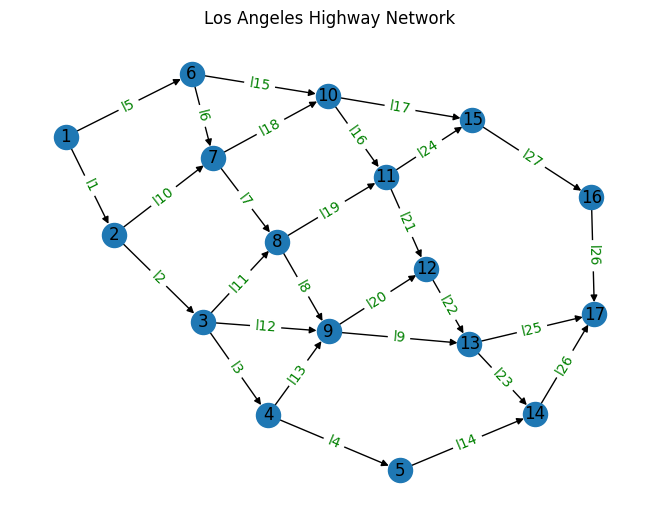

In [49]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= labels,
    font_color='green'
)
plt.axis('off')
plt.title("Los Angeles Highway Network")
plt.show()



## Point a
Find the shortest path between node 1 and 17. This is equivalent to the fastest path (path with shortest traveling time) in an empty network.



First, as a sanity check, we execute the shortest path algorithm provided by the `networkx`library

In [50]:
nx.shortest_path(G,1,17)

[1, 2, 3, 9, 13, 17]

Here we got that the shortest path in an empty network is $(1)→(2)→(3)→(9)→(13)→(17)$.



Now, let's compare it with the separable convex network flow optimization.

Given a multigraph $(V,E)$, and an **exogenous network flow** vector ${\nu} \in \mathrm{R}^V$ such that

\begin{equation}
	\sum_{i \in V} \nu_i = 0.
\end{equation}

Let $f \in \mathrm{R}^E$ be a network flow vector  satisfying the constraints

\begin{equation}
 f \ge \mathbf{0}, \quad Bf = \nu.
\end{equation}

And let $\psi_e(f_e)$ be a separable non-decreasing convex cost function $\psi_e(f_e)$ such that $\psi_e(0)=0$, this function is applied to every edge.

Therefore we have the following optimization problem, which will be solved using the library `cvxpy`:

\begin{equation}
\begin{aligned}
	f^* \in \ & \underset{\substack{f \in \mathrm{R}^{E}_+ \\ B f = \nu}}{\arg\min}
	& \sum_{e \in E} \psi_e (f_e).
\end{aligned}
\end{equation}



In [51]:
n_edges = B.shape[1]
n_nodes = B.shape[0]

tmp = np.zeros(n_nodes)
tmp[0] = 1
tmp[-1] = -1
# exogenous flow vector: one unit of flow enters the origin and exits the destination node
# the solution of the shortest path problem is actually independent on the throughput value because of the linearity
tau = 1
nu = tmp * tau



# Construct the problem.
flow = cp.Variable(n_edges)
objective = cp.Minimize(l.T @ flow)
constraints = [B @ flow == nu, flow >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for f is stored in `flow.value`.
path = np.around(flow.value, decimals=0, out=None)
print("Optimal flow array:\n",  path)
print("Optimal path:", [f"l{i[0]+1}" for i in list(np.argwhere(path==1))])

Optimal flow array:
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]
Optimal path: ['l1', 'l2', 'l9', 'l12', 'l25']


Therefore, following the order of edges proposed in the graph, the optiaml path to travel from $(1)$ to $(17)$ is:

$$(1) -l_1 → (2) -l_2 →(3)-l_{12} →(9)-l_9→ (13)-l_{25}→(17)$$

Which is congruent with the previous result using the shortest path algorithm.

## Point b
Find the maximum flow between node 1 and 17.

For this excercise, lets use the `maximum_flow` algorithm available in the `Networkx` library.

In [52]:
value, Gflow = nx.algorithms.flow.maximum_flow(G, 1, 17, capacity='capacity')

In [53]:
found_flow = np.zeros(n_edges)
edge_list = [e for e in edges]

for el in Gflow:
  for val in Gflow[el]:
    found_flow[edge_list.index((el,val))] = Gflow[el][val]

print("Max flow is: ", value)
print("With flow vector:",end=" ")
print(found_flow)

Max flow is:  22448
With flow vector: [ 8741. 13707.  8741.     0.     0.     0.  8741.     0.     0.     0.
  4624.  9083.  4624.     0.  4624.     0.  6297.  7068.  3835. 10355.
  3835.   825.  8258.   825.     0.  8258.  7893.  8258.]


As seen in the output of the algorithm, the maximum flow between the nodes $1$ and $17$ is $22448$ and the flow distribution can be observed inside the links of the following graph

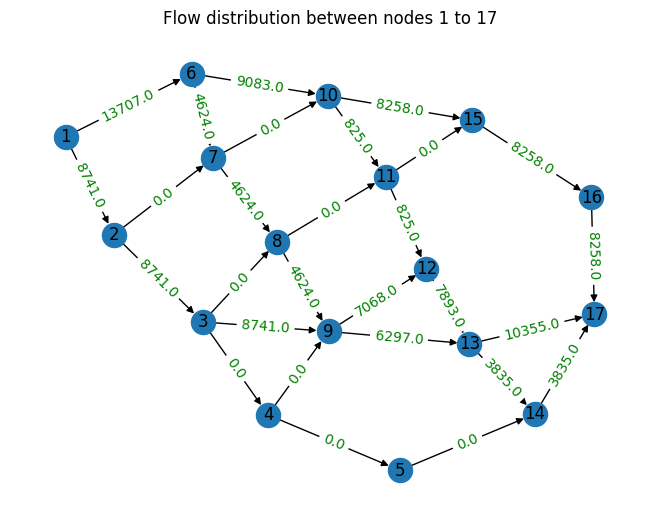

In [54]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= {e:i for i,e in zip(found_flow,edges)},
    font_color='green'
)
plt.axis('off')
plt.title("Flow distribution between nodes 1 to 17")
plt.show()

## Point c
Given the flow vector in flow.mat, compute the vector $\nu$ satisfying $ Bf = \nu
$
We have to verify that
\begin{equation}
 f \ge \mathbf{0}
\end{equation}

In [55]:
f>= 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

and also
\begin{equation}
	\sum_{i \in V} \nu_i = 0.
\end{equation}

In [56]:
# Compute net flow at each node
v = B @ f

# Compute inflows and outflows.
inflows = [max(flow_value, 0) for flow_value in v]
outflows = [min(flow_value, 0) for flow_value in v]

print("The vector v is:", v)
# Here we are verifying that it satisfies the zero-sum constraint
print("The total net flow =", sum(v))

print("The inflow relative to the given flow vector f is: v_+ =", inflows) #positive values
print("The outflow relative to the given flow vector f is: v_- =", outflows) #negative values


The vector v is: [ 16282   9094  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]
The total net flow = 0
The inflow relative to the given flow vector f is: v_+ = [16282, 9094, 19448, 4957, 0, 4768, 413, 0, 0, 1169, 0, 0, 0, 0, 0, 0, 0]
The outflow relative to the given flow vector f is: v_- = [0, 0, 0, 0, -746, 0, 0, -2, -5671, 0, -5, -7131, -380, -7412, -7810, -3430, -23544]


## Point d
Find the social optimum $f^*$ with respect to the delays on the different links $\tau_e(f_e)$. For this, minimize the cost function subject to the flow constraints.
$$\sum_{e\in\mathcal{E}}f_e\tau_e(f_e)=\sum_{e\in\mathcal{E}}\frac{f_el_e}{1-f_e/c_e}=\sum_{e\in\mathcal{E}}\left(\frac{l_ec_e}{1-f_e/c_e}-l_ec_e\right)$$

For this excercise we apply again the separable convex network flow optimization, using the $\nu$ found in the previous excersise and the proposed cost function, the distribution is presented in the graph below.

In [57]:

# exogenous flow vector: one unit of flow enters the origin and
# exits the destination node
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]




# Construct the problem.
fe = cp.Variable(n_edges)
function = cp.sum(cp.multiply(cp.multiply(l,C),cp.inv_pos(1 - fe/C))- cp.multiply(l,C))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0, fe<=C]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()
# The optimal value for f is stored in `f.value`.
opt_flow = fe.value
print("Social optimal flow:", np.around(opt_flow, decimals=0, out=None))
print("Optimal cost:", np.around(cost_opt, decimals=2, out=None))
social_opt = fe


Social optimal flow: [6375. 5665. 2905. 2905. 9907. 4528. 2951. 2487. 3018.  709.    0. 2761.
    0. 2905. 5379. 2766. 4900. 2287.  463. 2230. 3229. 5459. 2307.    0.
 6170. 5212. 4900. 4900.]
Optimal cost: 23997.16


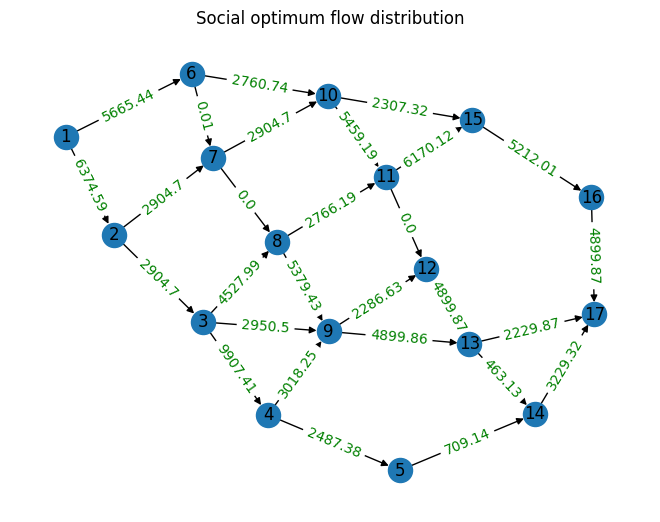

In [58]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= {e:i for i,e in zip(np.around(opt_flow, decimals=2, out=None),edges)},
    font_color='green'
)
plt.axis('off')
plt.title("Social optimum flow distribution")
plt.show()

## Point e
Find the Wardrop equilibrium $f^{(0)}$. For this, use the cost function
$$
 min \sum_e \int_0^{f_e} \tau_e(s)~\mathrm{d}s.
$$

The solution of the expression:
$$
 min \sum_e \int_0^{f_e} \frac{l_e}{1 - \frac{s}{c_e}}~\mathrm{d}s.
$$
Is the objective function:
$$
\ min \sum_e -l_e c_e \ln\left(1 - \frac{f_e}{c_e}\right)
$$
Subject to constraints:
$$
 Bf = \nu, f \geq 0
$$

In [59]:
B # Traffic matrix
n_edges #Number of edges of B

# Exogenous flow vector:
# flow entering the origin node is set as v[0], flow exiting the destination node is -v[0].
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]

# Coefficients for objective function
C # diagonal matrix
l # 1d array
fe = cp.Variable(n_edges) # Variable representing the flow on each edge

# Construct the problem
function = -cp.sum(cp.multiply(cp.multiply(C, l), cp.log(1 - cp.multiply(fe, cp.inv_pos(C)))))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned
result_w = prob.solve()
# The optimal value for f is stored in `fe.value`.
print("Wardrop equilibrium:", np.around(fe.value, decimals=1, out=None))


Wardrop equilibrium: [6349.6 6178.2 2037.9 2037.9 9932.4 4567.2 2738.1 2144.1 3270.7  171.5
   69.2 4071.1    0.  2037.9 5365.1 2203.  5162.7 2000.6  663.2 2944.5
 2866.2 5810.7 2436.6    0.  6644.8 4474.5 5162.7 5162.7]


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


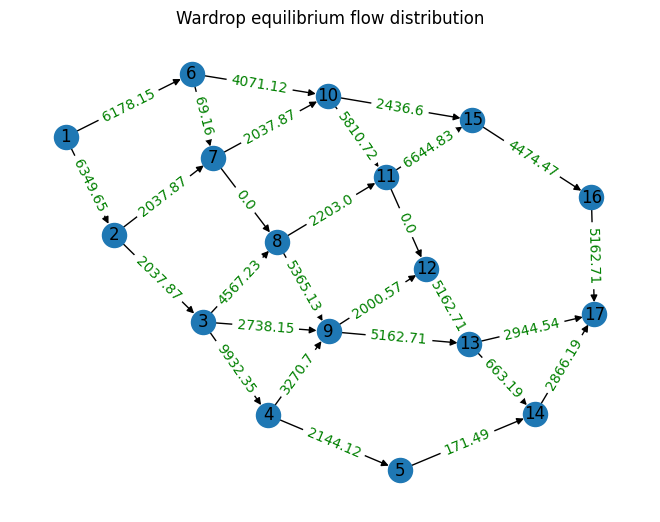

In [60]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= {e:i for i,e in zip(np.around(fe.value, decimals=2, out=None),edges)},
    font_color='green'
)
plt.title("Wardrop equilibrium flow distribution")
plt.axis('off')
plt.show()

The social cost under Wardrop equilibrium is:
$$
\sum_{e}f_e^{(0)}\tau_e(f_e^{(0)}),
$$

In [61]:
wardrop_f = fe
wardrop_cost = sum(wardrop_f.value*l/(1 - wardrop_f.value/C))
print("Wardrop cost: ",  np.around(wardrop_cost, decimals=1, out=None))

Wardrop cost:  24341.2


## Point f

Introduce tolls, such that the toll on link e is $\omega_e = \psi_{e}'(f_e^{*})-\tau_e (f_e^*)$. For the considered $\psi_e(f_e)$, $\omega_e = f_e^* \tau_e'(f_e^* )$, where $f_e^*$ is the flow at the system optimum. Now the delay on link e is given by $\tau_e(f_e ) + \omega_e$. compute the new Wardrop equilibrium $f ^{(\omega)}$ . What do you observe?

In [62]:
# exogenous flow vector: one unit of flow enters the origin and
# exits the destination node
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]
# Q and l store the coefficients of the quadratic
# and linear terms of the objective function.


# Construct the problem.
fe = cp.Variable(n_edges)
t_prime = cp.multiply(cp.multiply(l,C),cp.inv_pos(cp.power((C - social_opt.value),2)))
omega = cp.multiply(social_opt.value,t_prime)
function = cp.sum(-cp.multiply(cp.multiply(C,l),cp.log(1-cp.multiply(fe,cp.inv_pos(C)))) + cp.multiply(fe,omega))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result_w = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Wardrop equilibrium with tolls:", np.around(fe.value, decimals=2, out=None))
tolls_f = fe
wardrop_tolls_cost = sum(tolls_f.value*l/(1 - tolls_f.value/C))
print("Wardrop cost with tolls: ", wardrop_tolls_cost)


Wardrop equilibrium with tolls: [6373.17 5665.64 2904.65 2904.65 9908.83 4527.78 2950.12 2486.97 3018.41
  707.54    0.   2760.98    0.   2904.65 5381.04 2766.46 4899.78 2285.2
  463.16 2229.53 3229.62 5459.15 2307.52    0.   6170.05 5212.17 4899.78
 4899.78]
Wardrop cost with tolls:  23997.162424961676


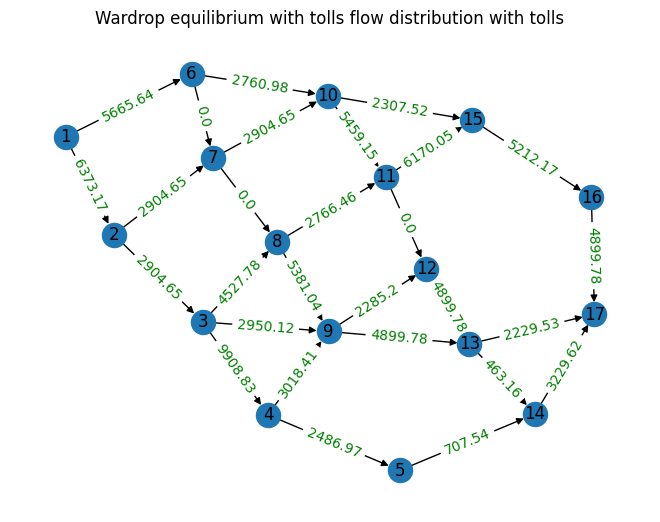

In [63]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= {e:i for i,e in zip(np.around(tolls_f.value, decimals=2, out=None),edges)},
    font_color='green'
)
plt.title("Wardrop equilibrium with tolls flow distribution with tolls")
plt.axis('off')
plt.show()

In [64]:
# Substraction of the social optimum flow and wardrop equilibrium with tolls
np.around(opt_flow-tolls_f.value, decimals=2, out=None)

array([ 1.41, -0.19,  0.04,  0.04, -1.41,  0.2 ,  0.38,  0.42, -0.16,
        1.61,  0.01, -0.24,  0.  ,  0.04, -1.62, -0.27,  0.09,  1.43,
       -0.03,  0.33, -0.3 ,  0.03, -0.2 ,  0.  ,  0.07, -0.16,  0.09,
        0.09])

As seen in the graph and the substraction above, the wardrop equilibrium gives a very good aproximation of the social optimum $f^*$ obtained in the numeral **d)**

## Point g

Instead of the total travel time, let the cost for the system be the total additional travel time compared to the total travel time in free flow, given by
$$
\psi_e (f_e) = f_e (\tau_e (f_e)- l_e)
$$

*   Compute the system optimum $f^*$ for the costs above.



From the numeral (d), we know:
$$
\sum_e f_e \tau_e(f_e) = \sum_e \left(\frac{l_e c_e}{1-\frac{f_e}{c_e}}-l_e c_e \right)
$$
The objective function will be:
$$
\psi_e (f_e) = min \sum_e \frac{l_e c_e}{1 - \frac{f_e}{c_e}} - l_e c_e - f_e l_e
$$
Subject to the constraints:
$$
 Bf = \nu, f \geq 0
$$

In [65]:
B # Traffic matrix
n_edges #Number of edges of B

# Exogenous flow vector:
# flow entering the origin node is set as v[0], flow exiting the destination node is -v[0].
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]

# Coefficients for objective function
C # diagonal matrix
l # 1d array
fe = cp.Variable(n_edges) # Variable representing the flow on each edge

# Construct the problem, psi function
function = cp.sum(cp.multiply(cp.multiply(l,C),cp.inv_pos(1 - fe/C))- cp.multiply(l,C) - cp.multiply(fe,l))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned
result = prob.solve()

# The optimal value for f is stored in `f.value`.
print("System optimum f*:", np.around(fe.value, decimals=1, out=None))
print("Total cost = ", np.around(result, decimals=1))
new_soc_flow = fe
new_soc_opt_value = fe.value


System optimum f*: [6393.9 5420.8 3243.7 3243.7 9888.1 4530.6 3051.6 2612.1 2895.4  973.1
    0.  2177.1    0.  3243.7 5357.5 2969.8 4839.8 2452.1  439.5 1893.8
 3409.3 5303.  2140.2    0.  6058.3 5383.9 4839.8 4839.8]
Total cost =  13550.2


*   Construct a toll vector $\omega^* $ such that the Wardrop equilibrium
$ f^{(\omega^*)}$
coincides with $f^*$. Compute the new Wardrop equilibrium with the constructed tolls $f^{(w^*)}$to verify your result.




The toll vector is defined as:
$$
  \omega_e^* = f_e^* \tau_e'(f_e^*)
$$

In order to obtain the toll vector, we need to derivate the next expression and multiply it by $f_e^*$.

$$ \psi_e (f_e) = f_e (\tau_e (f_e)- l_e) $$

Since, $l_e$ is a constant, the result of the derivation is:
$$
  \tau_e'(f_e^*) = \frac{l_e c_e}{(c_e-f_e^*)^2}
$$


We also have that the objective function is:
$$
f^{(w^*)} =  min \sum_e \int_0^{f_e} \psi_e(s)~\mathrm{d}s + \omega_e^* f_e
$$

$$
f^{(w^*)} = min \sum_e -l_e c_e \ln\left(1 - \frac{f_e}{c_e}\right) - f_e l_e+ f_e \omega_e^*
$$

In [66]:
B # Traffic matrix
n_edges #Number of edges of B

# Exogenous flow vector:
# flow entering the origin node is set as v[0], flow exiting the destination node is -v[0].
nu = np.zeros(v.shape[0])
nu[0] = v[0]
nu[-1] = -v[0]

# Coefficients for objective function
C # diagonal matrix
l # 1d array
fe = cp.Variable(n_edges) # Variable representing the flow on each edge

t_prime = cp.multiply(cp.multiply(l,C),cp.inv_pos(cp.power((C - new_soc_opt_value),2)))
omega = cp.multiply(new_soc_opt_value,t_prime)

function = cp.sum(-cp.multiply(cp.multiply(C,l),cp.log(1-cp.multiply(fe,cp.inv_pos(C)))) - cp.multiply(fe,l) + cp.multiply(fe,omega))
objective = cp.Minimize(function)
constraints = [B @ fe == nu, fe >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
new_result_w = prob.solve()
print("New Wardrop equilibrium:", np.around(fe.value, decimals=1, out=None))
new_wardrop_f = fe
new_wardrop_cost = sum(new_wardrop_f.value*l/(1 - new_wardrop_f.value/C) - new_wardrop_f.value*l)
print("New Wardrop cost: ",np.around (new_wardrop_cost, decimals = 1))

New Wardrop equilibrium: [6393.8 5420.9 3243.6 3243.6 9888.2 4530.6 3051.3 2611.9 2895.4  972.9
    0.  2177.3    0.  3243.6 5357.6 2969.9 4839.9 2452.2  439.4 1893.7
 3409.3 5303.1 2140.3    0.  6058.2 5383.9 4839.9 4839.9]
New Wardrop cost:  13550.2


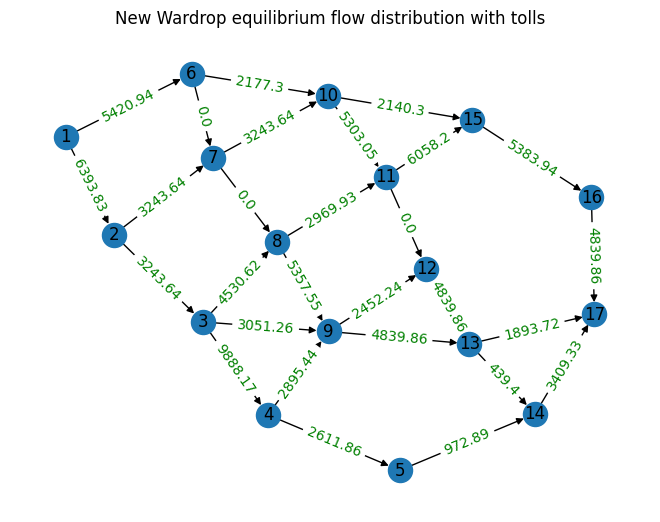

In [67]:
nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= {e:i for i,e in zip(np.around(new_wardrop_f.value,decimals=2, out=None),edges)},
    font_color='green'
)
plt.title("New Wardrop equilibrium flow distribution with tolls")
plt.axis('off')
plt.show()

In [68]:
# Substraction of the social optimum flow and wardrop equilibrium with tolls
np.around(new_soc_opt_value-new_wardrop_f.value, decimals=2, out=None)

array([ 0.08, -0.14,  0.05,  0.05, -0.08, -0.06,  0.35,  0.24, -0.  ,
        0.22,  0.  , -0.19,  0.  ,  0.05, -0.02, -0.17, -0.04, -0.19,
        0.11,  0.05, -0.06, -0.01, -0.07,  0.  ,  0.06, -0.02, -0.04,
       -0.04])

As seen in the graph and the substraction above, the wardrop equilibrium gives a very good aproximation of the new social optimum $f^*$ calculated above.